# Multivariate Encoding of fMRI data

![alt text](plot_tmap.png)

**Lukas Snoek**, Programming: The Next Step

## Contents

**Introduction**

**Setting up environment**

**Software structure**

* From single trial to MVPA data
* Creating distance matrices
* Creating RDM regressors
* Testing distance matrices

**Main analysis & results**

## Introduction

Most fMRI studies use **mass-univariate** analyses to test involvement of brain areas.
* Testing involvement of each voxel separately (> 200,000 tests!)
* Stringent multiple comparison correcting necessary
* Neglecting spatial dependence between voxels

**Multivariate analyses** (also: **M**ulti**v**ariate **P**attern **A**nalyses, MVPA) are becoming increasingly popular
* Higher SNR
* Less independent features (voxels) within one test

## Multivariate encoding

A multivariate encoding analysis uses multidimensional distance metrics to evaluate whether a factor (or 'class') is encoded within a certain region of interest (ROI). 

***




It investigates the simple hypothesis that: 

**if** a factor is encoded in a ROI ... **then** trials of the **_same_** factor should have smaller distances than trials from **_different_** factors.

The analyses is run within ROIs instead of for each voxel separately (i.e. multivariate!), increasing SNR and reducing multiple comparisons.

## Dataset
The analysis is explained/demonstrated using a sample single-trial fMRI dataset. This dataset has just **_one_** factor with **_three_** levels.

The trials are organized as follows:
* Trials 1-40: level **1**
* Trials 41:80: level **2**
* Trials 81:120: level **3**

## Import the module
To start the analysis, just import the module!

In [3]:
import os
import sys
import cPickle

script_dir = '/home/lukas/Dropbox/ResMas_UvA/Thesis/Git/Analysis_scripts/modules/'
working_dir = '/media/lukas/Data/Matlab2Python/FirstLevel/'

sys.path.append(script_dir)
os.chdir(working_dir)

# Here we import the module!
import MultivariateEncoding as ME

## Single trial to MVPA data
In the first part of the analysis, the following is done:
* Load in the single-trial data (matrix of trials X features)
* Index data by specific mask (i.e. only data from specific ROI)
* Save, per subject, the data into a separate file

In [4]:
# Setting parameters 
mask = '/media/lukas/Data/Matlab2Python/FSL_masks/ROIs/Lateralized_masks/IFG_parsopercularis_left.nii.gz'
subject_stem = 'HWW'
mask_threshold = 30
verbose = 1

# create_subject_mats is the most important function! 
ME.create_subject_mats(mask,subject_stem,mask_threshold,verbose)
ME.merge_runs(verbose)

Processing HWW_003-20140228-0007-WIPPM_Zinnen2 ...  done.
Processing HWW_003-20140228-0005-WIPPM_Zinnen1 ...  done.
Processing HWW_001-20140205-0006-WIPPM_Zinnen2 ...  done.
Processing HWW_001-20140205-0005-WIPPM_Zinnen1 ...  done.
Processing HWW_006-20140314-0004-WIPPM_Zinnen1 ...  done.
Processing HWW_004-20140307-0006-WIPPM_Zinnen2 ...  done.
Processing HWW_004-20140307-0005-WIPPM_Zinnen1 ...  done.
Processing HWW_005-20140228-0005-WIPPM_Zinnen1 ...  done.
Processing HWW_005-20140228-0006-WIPPM_Zinnen2 ...  done.
Processing HWW_002-20140203-0005-WIPPM_Zinnen1 ...  done.
Processing HWW_002-20140203-0006-WIPPM_Zinnen2 ...  done.
Merging subject 1 ...  done.
Merging subject 2 ...  done.
Merging subject 3 ...  done.
Merging subject 4 ...  done.
Merging subject 5 ...  done.


## Creating distance matrices
Let's load the data from a random subject.

In [5]:
subject_x = cPickle.load(open(working_dir + '/mvpa_mats/HWW_004_merged.cPickle'))

Let's take a look at the data from subject_x, using the imshow-function, which returns a heatmap of the data in the format of features X trials

Populating the interactive namespace from numpy and matplotlib


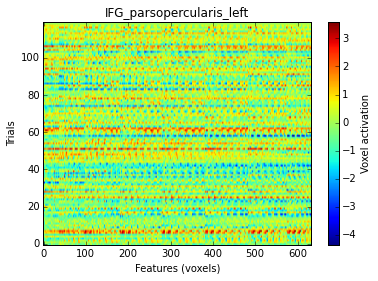

In [6]:
import matplotlib.pyplot as plt
%pylab inline

plt.imshow(subject_x.data,aspect='auto',origin='lower')
plt.colorbar(label = 'Voxel activation')
plt.xlabel('Features (voxels)')
plt.ylabel('Trials')
plt.title(subject_x.mask_name[:-7])

## Creating distance matrices
To create a pairwise distance matrix, we simply calculate all inter-trial (Euclidian) distances, using the function create_RDM(). Let's plot it again.
(RDM stands for **R**epresentational **D**issimilarity **M**atrix, just a fancy word for a pairwise distance matrix...)

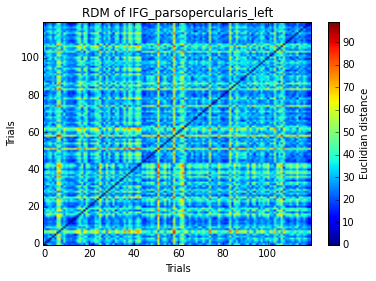

In [7]:
# Call function
RDM,test_idx = ME.create_RDM(subject_x, 1, z_thres = None)

# Plot RDM
plt.imshow(RDM, aspect='auto',origin='lower')
plt.colorbar(label = 'Euclidian distance')
plt.xlabel('Trials')
plt.ylabel('Trials')
plt.title('RDM of ' + subject_x.mask_name[:-7])

## Creating RDM regressors
To test the hypothesis that within-factor trials are more similar than across-factor trials, a "predictor-RDM" needs to be created. The function create_regressors() does this by parsing the .class_labels attribute of a subject-file and creating an RDM with zeros for within-factor distances and ones for between-factor distances.

<matplotlib.colorbar.Colorbar instance at 0x7f02599445f0>

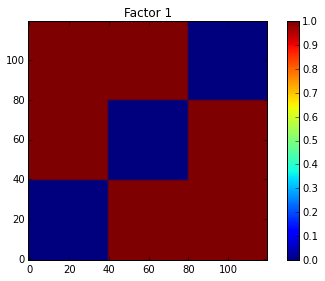

In [8]:
# Create and plot predictor RDM
predictor_RDM = ME.create_regressors(subject_x, test_idx, plot = 1)
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f02598b3cb0>

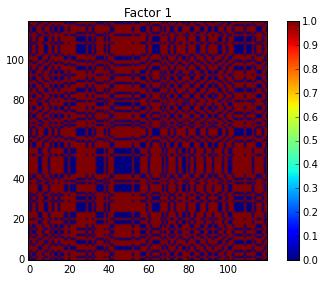

In [9]:
# The order of the trials doesn't matter!
from random import shuffle
shuffle(subject_x.class_labels)
shuffled_RDM = ME.create_regressors(subject_x, test_idx, plot = 1)
plt.colorbar()

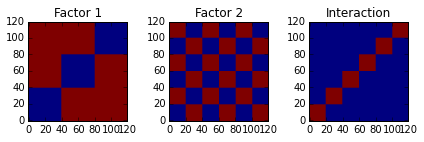

In [10]:
# Also works for factorial designs! 
fact1 = ['A'] * 40 + ['B'] * 40 + ['C'] * 40
fact2 = [1] * 20 + [2] * 20 + [1] * 20 + [2] * 20 + [1] * 20 + [2] * 20
subject_x.class_labels = zip(fact1,fact2)
factorial_RDM = ME.create_regressors(subject_x, test_idx, plot = 1)

## Testing distance matrices
Now, to test whether the factor is encoded in this particular ROI, simply regress the (vectorized) observed RDM onto the (vectorized) predictor-RDM.

In [12]:
# Call test_RDM to regress observed RDM onto predictor-RDM(s)
t_val, p_val = ME.test_RDM(observed = RDM, predictors = predictor_RDM)

print "The ROI %s yields a t-value of %f with a corresponding p-value of %f." % (subject_x.mask_name,t_val, p_val)

The ROI IFG_parsopercularis_left.nii.gz yields a t-value of 0.484265 with a corresponding p-value of 0.628213.


## Main analysis & results sample dataset
The module contains the function *main()*, which integrates the previously discussed functions so that it calculates the t-values for different (predefined) ROIs in one go. 

I won't show it here, because it takes about 40 minutes... <br />
(But hey, a higher-level, whole-brain mass-univariate analysis takes about 30 hours!)

Additionally, the main() function does the following:
* Averages RDMs over subjects!
* Backprojection of t-values on a "t-map"
* T-values are corrected for multiple comparisons (n = amount of ROIs)
* Plotting of t-map 

![alt text](plot_tmap.png)

# Thank you!